In [ ]:
import os
import numpy as np
import string
import pandas as pd
import tarfile
from joblib import dump
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import operator
from sklearn import model_selection
import nltk
from nltk.corpus import stopwords


# **Data Preprocessing**

In [44]:
# Extract the 20 newsgroups dataset from a tar file
tar = tarfile.open("20_newsgroups.tar")
tar.extractall()
tar.close()

In [45]:
# Creates folders for tar files
f_paths=[]
i=-1
path="20_newsgroups"
folderlist=os.listdir(path)
if ".DS_Store" in folderlist:
  folderlist.remove('.DS_Store')
for folder in folderlist:
  i+=1
  filelist=os.listdir(path+'/'+folder)
  for file in filelist:
    f_paths.append((path+'/'+folder+'/'+file,i))
len(f_paths)

# Save the names of the target classes
np.save('target_names.npy', folderlist)

In [46]:
# Split the file paths into training and testing sets
x_train,x_test=model_selection.train_test_split(f_paths)
len(x_train),len(x_test)

(14997, 5000)

In [47]:
# Create a dataframe for the training and testing sets
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
for i in range(len(x_train)):
  X_train.append(x_train[i][0])
  Y_train.append(x_train[i][1])
for i in range(len(x_test)):
  X_test.append(x_test[i][0])
  Y_test.append(x_test[i][1])
# Convert lists of labels into numpy arrays
Y_train=(np.array([Y_train])).reshape(-1)
Y_test=(np.array([Y_test])).reshape(-1)
Y_train.shape,Y_test.shape

((14997,), (5000,))

In [48]:
# Download the list of stopwords from NLTK to filter out in the data processing
nltk.download('stopwords')
stop=set(stopwords.words("english"))
# Combine stopwords with all string punctuation
stop_words=list(stop)+list(set(string.punctuation))

[nltk_data] Downloading package stopwords to /Users/redap/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
# Initialize a dictionary to build the vocabulary from the training data
vocab={}
count =0
for filename in X_train:
  count+=1
  f = open(filename,'r',errors='ignore')
  record=f.read()
  words=record.split()
  for word in words:
    if len(word)>2:
      if word.lower() not in stop_words:
        if word.lower() in vocab:
          vocab[word.lower()]+=1
        else:
          vocab[word.lower()]=1
  f.close()

In [50]:
# Sort the vocabulary based on the frequency of each word, in descending order
sorted_vocab = sorted(vocab.items(), key= operator.itemgetter(1), reverse= True) 

In [51]:
# Select the top 2000 words to be feature names
feature_names = []
for i in range(len(sorted_vocab)):
    if(sorted_vocab[2000][1] <= sorted_vocab[i][1]):
        feature_names.append(sorted_vocab[i][0])

# Save the feature names to a CSV file for use in Streamlit App
feature_names_df = pd.DataFrame(feature_names, columns=['word'])
feature_names_df.to_csv('feature_names.csv', index=False)
print(len(feature_names))

2007


In [52]:
df_train=pd.DataFrame(columns=feature_names)
df_test=pd.DataFrame(columns=feature_names)

In [53]:
# Bag of Words
count_train,count_test=0,0

# Transforming each file in X_train into a row in the dataframe df_train having columns as feature names and values as the frequency of that feature name i.e that word
for filename in X_train:
  count_train+=1
  df_train.loc[len(df_train)]=np.zeros(len(feature_names))
  f = open(filename,'r',errors='ignore')
  record=f.read()
  words=record.split()
  for word in words:
    if word.lower() in df_train.columns:
      df_train[word.lower()][len(df_train)-1]+=1 
  f.close()
  
# Transforming each file in X_test into a row in the dataframe df_test having columns as feature names and values as the frequency of that feature name i.e that word  
for filename in X_test:
  count_test+=1
  df_test.loc[len(df_test)]=np.zeros(len(feature_names))
  f = open(filename,'r',errors='ignore')
  record=f.read()
  words=record.split()
  for word in words:
    if word.lower() in df_test.columns:
      df_test[word.lower()][len(df_test)-1]+=1
  f.close()
  

In [54]:
X_train=df_train.values
X_test=df_test.values

# **Model Development and Evaluation**

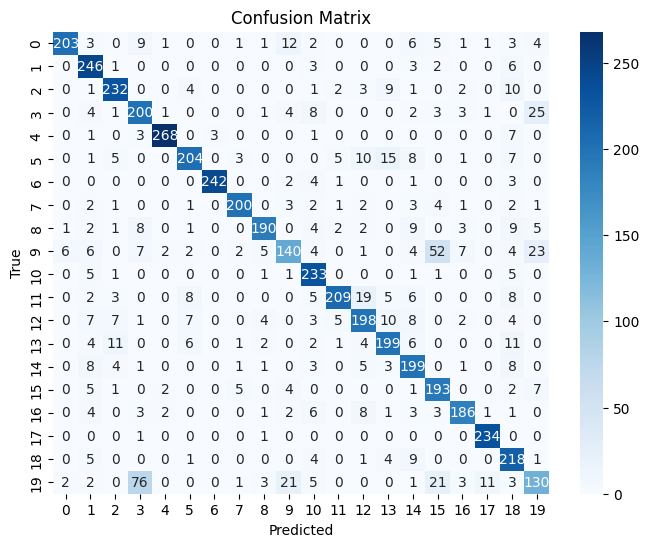

              precision    recall  f1-score   support

           0       0.96      0.81      0.88       252
           1       0.80      0.94      0.86       261
           2       0.87      0.88      0.87       265
           3       0.65      0.79      0.71       253
           4       0.97      0.95      0.96       283
           5       0.87      0.79      0.83       259
           6       0.99      0.96      0.97       253
           7       0.93      0.90      0.92       223
           8       0.90      0.80      0.85       237
           9       0.74      0.53      0.62       265
          10       0.80      0.94      0.87       248
          11       0.92      0.79      0.85       265
          12       0.78      0.77      0.78       256
          13       0.81      0.81      0.81       247
          14       0.73      0.85      0.79       234
          15       0.68      0.88      0.77       220
          16       0.89      0.84      0.86       221
          17       0.94    

In [55]:
# Model Evaluation
clf=MultinomialNB()
clf.fit(X_train,Y_train)
Y_pred=clf.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(Y_test), yticklabels=np.unique(Y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report and R^2 Score
print(classification_report(Y_test,Y_pred))
print("R^2 Test: ",clf.score(X_test,Y_test))

# **Save Model**

In [56]:
#Save the model for use in demo
model_dir = '/Documents/GitHub/CS481/model_creation/' 
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path = os.path.join(model_dir, 'multinomial_nb_model.joblib')
dump(clf, model_path)


['/Users/redap/Documents/GitHub/CS481/multinomial_nb_model.joblib']